In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST MT 2018
---

## VEST Documentation

### Election Results

#### Sources
Election results from Montana Secretary of State (https://sosmt.gov/elections/results/)

### Shapefiles

#### Sources
Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program. 

### Processing
The A/B subdivisions of Precinct 16 and Precinct 33 in Lewis and Clark were added based on county precinct maps.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_mt_18 = gp.read_file("./raw-from-source/VEST/mt_2018/mt_2018.shp")

In [3]:
vest_mt_18.crs

{'init': 'epsg:4269'}

<AxesSubplot:>

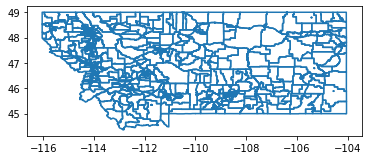

In [4]:
vest_mt_18.boundary.plot()

In [5]:
vest_mt_18.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G18USSRROS',
       'G18USSDTES', 'G18USSLBRE', 'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA',
       'G18CSCRGRE', 'G18CSCDREN', 'G18CSCLROO', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for MT

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Montana"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
mt_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Created `2018-GeneralPrecinct-by-Precinct_Votes.csv` from `2018-GeneralPrecinct-by-Precinct_Votes.xlsx` by opening in Excel, removing the first header row, and saving as a csv. No file modifications were made. 

In [7]:
#Load in clean SOS file
elections_2018 = pd.read_csv("./raw-from-source/SOS/2018-GeneralPrecinct-by-Precinct_Votes.csv")

In [8]:
elections_2018.shape

(14595, 8)

In [9]:
elections_2018.head()

,CountyName,PrecinctName,RaceName,PartyCode,Votes,NameOnBallot,HouseDistrict,SenateDistrict
0,Beaverhead,PRECINCT 01,UNITED STATES SENATOR,REP,159,MATT ROSENDALE,House District 72,Senate District 36
1,Beaverhead,PRECINCT 02,UNITED STATES SENATOR,REP,452,MATT ROSENDALE,House District 72,Senate District 36
2,Beaverhead,PRECINCT 03,UNITED STATES SENATOR,REP,471,MATT ROSENDALE,House District 72,Senate District 36
3,Beaverhead,PRECINCT 04,UNITED STATES SENATOR,REP,109,MATT ROSENDALE,House District 72,Senate District 36
4,Beaverhead,PRECINCT 05,UNITED STATES SENATOR,REP,104,MATT ROSENDALE,House District 72,Senate District 36


### Prepare to Pivot Election Results

In [10]:
#Filter down to the offices we need
office_list = ['UNITED STATES SENATOR','UNITED STATES REPRESENTATIVE','CLERK OF THE SUPREME COURT']
elections_2018 = elections_2018[elections_2018["RaceName"].isin(office_list)]

In [11]:
#Create a list of candidates we need based on VEST's file
candidate_list = ["Matt Rosendale","Jon Tester","Rick Breckenridge",
                  "Greg Gianforte","Kathleen Williams","Elinor Swanson",
                  "Bowen Greenwood","Rex Renk","Roger Roots"]

#Filter the file down to just those candidates
elections_2018=elections_2018[elections_2018["NameOnBallot"].isin([x.upper() for x in candidate_list])]

In [12]:
elections_2018["NameOnBallot"].unique()

array(['MATT ROSENDALE', 'JON TESTER', 'RICK BRECKENRIDGE',
       'GREG GIANFORTE', 'KATHLEEN WILLIAMS', 'ELINOR SWANSON',
       'BOWEN GREENWOOD', 'REX RENK', 'ROGER ROOTS'], dtype=object)

In [13]:
# Change column names to match the county fips dict
elections_2018.loc[elections_2018['CountyName'] == 'Lewis & Clark', 'CountyName'] = 'Lewis and Clark'

#Map to the correct FIP
elections_2018["county"]=elections_2018["CountyName"].map(mt_fips_dict).fillna(elections_2018["CountyName"])

#Print out the FIPS to make sure they all are in the correct format
elections_2018["county"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '057', '055', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111'], dtype=object)

In [14]:
print(elections_2018["CountyName"].nunique())
print(len(mt_fips_dict))

56
56


In [15]:
#Clean up the precinct column by striping the white space
elections_2018["PrecinctName"]=elections_2018["PrecinctName"].str.strip()

#Create a column to pivot one by concatenating the FIPS with the precinct
elections_2018["pivot_col"]=elections_2018["county"]+elections_2018["PrecinctName"]

### Pivot Election Results

In [16]:
#Run the pivot
pivoted_2018 = pd.pivot_table(elections_2018,values=["Votes"],index=["pivot_col"],columns=["NameOnBallot"],aggfunc=sum)

#Fill NA values w/ 0
pivoted_2018 = pivoted_2018.fillna(0)

#Clean the columns
pivoted_2018.reset_index(drop=False,inplace=True)
pivoted_2018.columns = pivoted_2018.columns.droplevel(0)

In [17]:
#Print the df to get a sense for it
pivoted_2018.head()

NameOnBallot,,BOWEN GREENWOOD,ELINOR SWANSON,GREG GIANFORTE,JON TESTER,KATHLEEN WILLIAMS,MATT ROSENDALE,REX RENK,RICK BRECKENRIDGE,ROGER ROOTS
0,001PRECINCT 01,174,9,180,251,231,159,197,12,26
1,001PRECINCT 02,463,21,494,233,199,452,167,28,38
2,001PRECINCT 03,489,16,509,246,219,471,185,22,30
3,001PRECINCT 04,118,6,117,50,44,109,31,9,10
4,001PRECINCT 05,102,1,106,28,27,104,20,1,5


In [18]:
pivoted_2018.columns

Index(['', 'BOWEN GREENWOOD', 'ELINOR SWANSON', 'GREG GIANFORTE', 'JON TESTER',
       'KATHLEEN WILLIAMS', 'MATT ROSENDALE', 'REX RENK', 'RICK BRECKENRIDGE',
       'ROGER ROOTS'],
      dtype='object', name='NameOnBallot')

In [19]:
#Rename the columns
pivoted_2018.columns = ["join_col",'G18CSCRGRE','G18HALLSWA','G18HALRGIA','G18USSDTES',
                        'G18HALDWIL','G18USSRROS','G18CSCDREN','G18USSLBRE','G18CSCLROO']

In [20]:
#Add in a column with the state, county and precinct name
pivoted_2018["STATEFP10"]="30"
pivoted_2018["COUNTYFP10"]=pivoted_2018["join_col"].str[0:3]
pivoted_2018["NAME"]=pivoted_2018["join_col"].str[3:]

In [21]:
pivoted_2018.head()

,join_col,G18CSCRGRE,G18HALLSWA,G18HALRGIA,G18USSDTES,G18HALDWIL,G18USSRROS,G18CSCDREN,G18USSLBRE,G18CSCLROO,STATEFP10,COUNTYFP10,NAME
0,001PRECINCT 01,174,9,180,251,231,159,197,12,26,30,001,PRECINCT 01
1,001PRECINCT 02,463,21,494,233,199,452,167,28,38,30,001,PRECINCT 02
2,001PRECINCT 03,489,16,509,246,219,471,185,22,30,30,001,PRECINCT 03
3,001PRECINCT 04,118,6,117,50,44,109,31,9,10,30,001,PRECINCT 04
4,001PRECINCT 05,102,1,106,28,27,104,20,1,5,30,001,PRECINCT 05


In [22]:
#Take a look at VEST's file
vest_mt_18.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G18USSRROS',
       'G18USSDTES', 'G18USSLBRE', 'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA',
       'G18CSCRGRE', 'G18CSCDREN', 'G18CSCLROO', 'geometry'],
      dtype='object')

In [23]:
#Reorder the election result df's columns to match VEST's
pivoted_2018 = pivoted_2018[['STATEFP10', 'COUNTYFP10', 'NAME','G18USSRROS',
       'G18USSDTES', 'G18USSLBRE', 'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA',
       'G18CSCRGRE', 'G18CSCDREN', 'G18CSCLROO',"join_col"]]

#Create a join column in the VEST file
vest_mt_18["join_col"]=vest_mt_18['COUNTYFP10']+vest_mt_18['NAME']

In [31]:
pivoted_2018.shape

(669, 13)

## Compare Election Results Totals

### Compare Total Votes

In [24]:
races = [x for x in vest_mt_18.columns if 'G18' in x]
races

['G18USSRROS',
 'G18USSDTES',
 'G18USSLBRE',
 'G18HALRGIA',
 'G18HALDWIL',
 'G18HALLSWA',
 'G18CSCRGRE',
 'G18CSCDREN',
 'G18CSCLROO']

In [25]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_mt_18[i])
    sum_var_2 += np.sum(pivoted_2018[i])
print(sum_var_1)
print(sum_var_2)

1489106
1489106


### Compare Race Totals

In [26]:
for race in races:
    diff_val = sum(vest_mt_18[race])-sum(pivoted_2018[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL")

G18USSRROS: EQUAL
G18USSDTES: EQUAL
G18USSLBRE: EQUAL
G18HALRGIA: EQUAL
G18HALDWIL: EQUAL
G18HALLSWA: EQUAL
G18CSCRGRE: EQUAL
G18CSCDREN: EQUAL
G18CSCLROO: EQUAL


### Compare County Totals

In [27]:
diff_counties=[]
for i in races:
    diff = pivoted_2018.groupby(["COUNTYFP10"]).sum()[i]-vest_mt_18.groupby(["COUNTYFP10"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(race, diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(race + ' county totals: EQUAL')

G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL
G18CSCLROO county totals: EQUAL


# Precinct Shapefile

## Load in the shapefiles

### 2020 TIGER/Line

> Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program.

Link to the 2020 TIGER/Line files for MT, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/30_MONTANA/30/

In [28]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_30_vtd20/tl_2020_30_vtd20.shp')

In [29]:
tiger_vtd.head(1)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,30,049,000027,30049000027,A,PCT 27,PCT 27,00,G5240,N,29808693,741,+46.7492670,-112.0442420,"POLYGON ((-112.08980 46.78522, -112.05939 46.7..."


In [30]:
tiger_vtd.shape

(666, 15)

<AxesSubplot:>

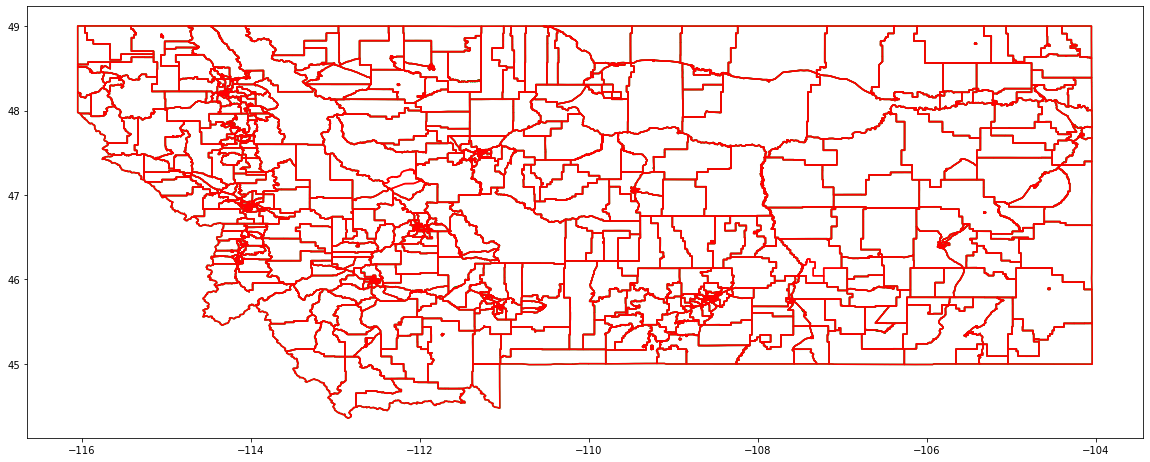

In [32]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(20,20),color="green")
vest_mt_18.boundary.plot(figsize=(20,20),ax=ax,color="red")

With a cursory look, this looks correct. 

### Shp from SOS

> Precinct shapefile primarily from Dave Ritts at the Montana State Library, pending submission to the U.S. Census Bureau's 2020 Redistricting Data Program.

Link to the shapefile from the SOS: https://mslservices.mt.gov/Geographic_Information/Data/DataList/datalist_Details.aspx?did=%7bdbd29997-21d8-4af1-9d87-5c5134775995%7d
Navigate to "Download Data", select "MontanaVotingPrecincts_shp.zip". 

Confirming whether this file is the same as the TIGER/Line file. 

In [37]:
mt_shp = gp.read_file('./raw-from-source/SOS/MontanaVotingPrecincts_shp/VotingPrecincts.shp')

In [38]:
mt_shp.head(1)

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,2012-07-31,4362,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52..."


In [40]:
mt_shp.shape

(666, 17)

In [42]:
mt_shp.crs

{'init': 'epsg:32100'}

In [43]:
vest_mt_18 = vest_mt_18.to_crs(epsg=32100)

<AxesSubplot:>

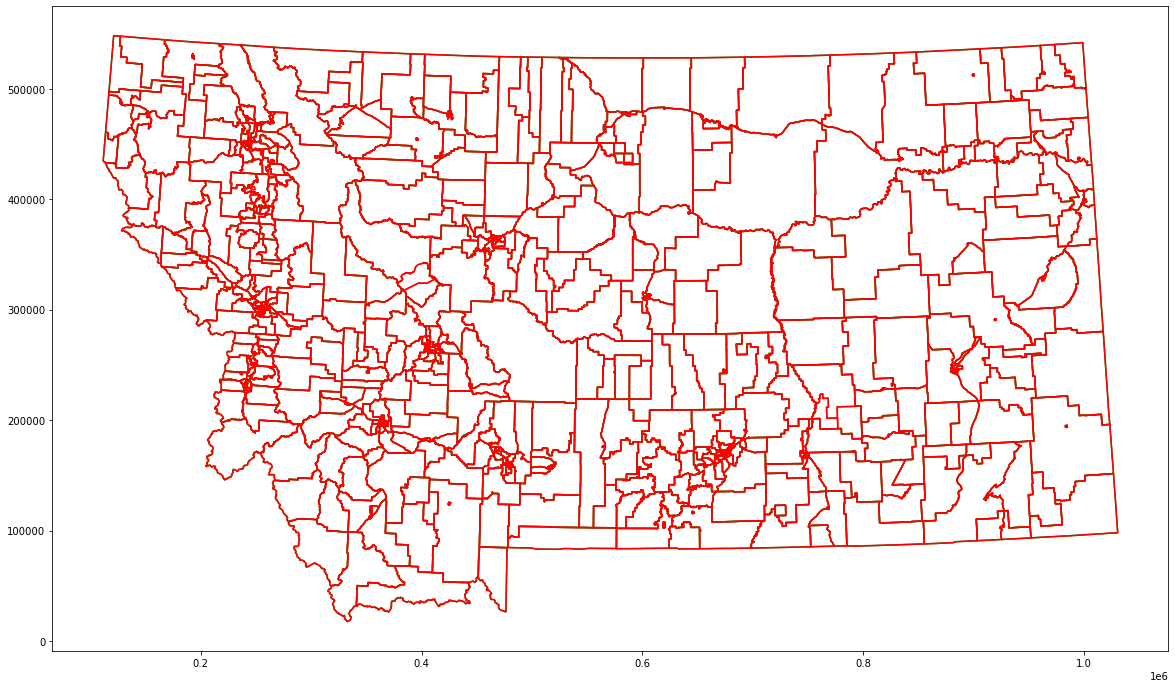

In [44]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = mt_shp.boundary.plot(figsize=(20,20),color="green")
vest_mt_18.boundary.plot(figsize=(20,20),ax=ax,color="red")

Ultimately, the TIGER/Line and the file directly from the SOS look the same, though the columns in them differ slightly. 

Leaving it to the person assigned to this state to determine which file to use, that will make joining to the election results and replicating VEST's file easier. 